# SCI Dataset - Profiling

In [169]:
import warnings
import string

warnings.simplefilter(action="ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import torch
import transformers as tr

pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer

sns.set_theme(style="darkgrid", palette="colorblind")
sns.set(rc={"figure.figsize": (11.5, 8.5), "figure.dpi": 100})

from utils.data_profiling import band_proportions_periodic, sns_multi_time_series, topn_icd_in_year, sci_subset, median_los_per_band, missing_data, single_boxplot
from dataset import SCIData, SCICols

%load_ext autoreload
%autoreload 1
%aimport utils.data_profiling, dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stybl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [170]:
icd10 = pd.read_hdf("data/icd10.h5", "ICD10_Codes")



In [171]:
sci = SCIData.load("data/sci.h5")  # .derive_all()



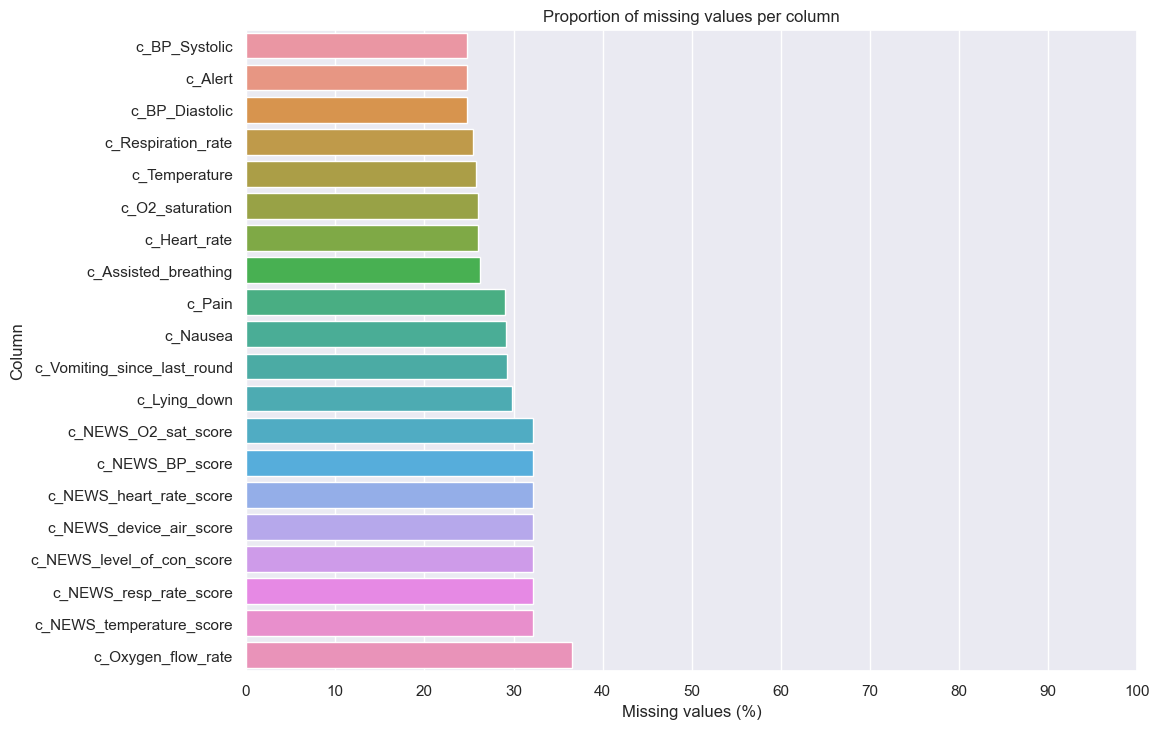

In [172]:
# fig, ax = plt.subplots(figsize=(10,15))
missing_data(sci, SCICols.news_data)


## NEWS Parameters

### O2 Saturation
We consider outliers to be values under `3` standard deviations of the mean (<40.37), or any value >100 (as this is impossible). We correct outliers based on the recorded NEWS O2 saturation score. We set their value to the midpoint of the reference range for scores 0-2. For score = 3, we leave the value as-is.

The NEWS specification gives two reference scales [RCP17, pp.44]:
 - SpO2_1: By default.
 - SpO2_2: For patients with a prescribed oxygen saturation requirement of 88–92% (eg., in patients with hypercapnic respiratory failure).

We assume COPD (`J44.*` appearing in the patient's Diag codes) as triggering SpO2_2. If the patient is receiving oxygen, there is ambiguity as to whether a high O2 score means high or low saturation. In that case, we delete those values. SpO2_2 patients with score=0 will be assigned the midpoint of the range as normal.

A sizeable proportion of entries have an O2 saturation value but no score, or vice versa. We calculate the score for those given the scales in [RCP17]. 

In [173]:
(sci.c_NEWS_O2_sat_score.isna() & sci.c_O2_saturation.notna()).sum()

10645

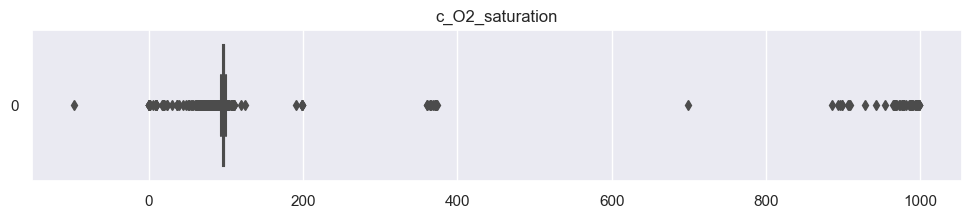

In [174]:
single_boxplot(sci, "c_O2_saturation")



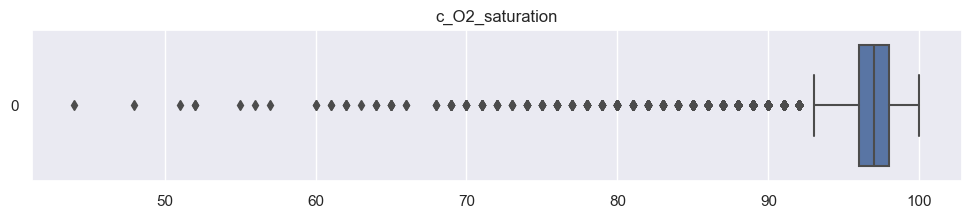

In [175]:
scii = sci.clean_O2_saturation()
single_boxplot(scii, "c_O2_saturation")



### Blood Pressure

We apply criteria from [Fernandes20]. To be included, values must be:
 - Diastolic: Within $5 \leq d \leq 200$
 - Systolic: Within $20 \leq s \leq 300$ and it must hold $s \geq d+5$

As before, we fill missing systolic NEWS scores using the raw value where available. We infer missing systolic BP values from the score, if one is available and is not = 3, as a score of 3 is ambiguous.

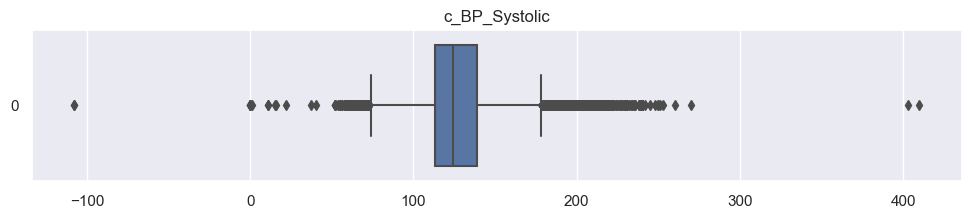

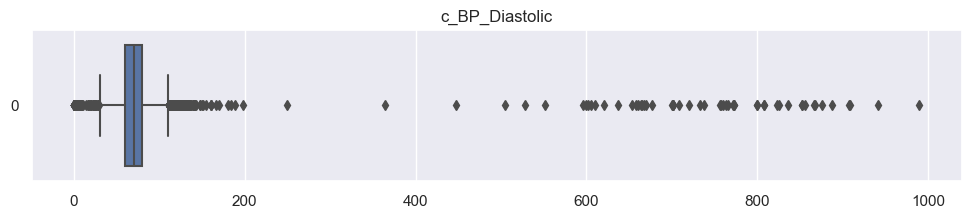

In [176]:
single_boxplot(sci, "c_BP_Systolic")
single_boxplot(sci, "c_BP_Diastolic")



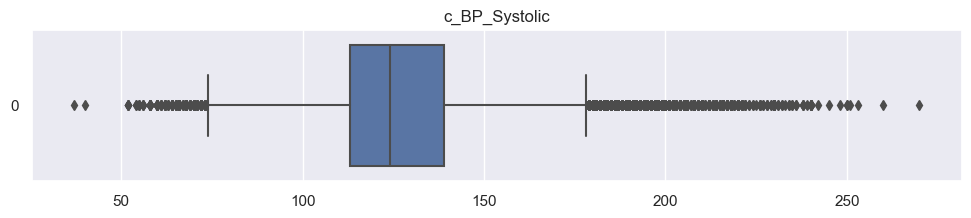

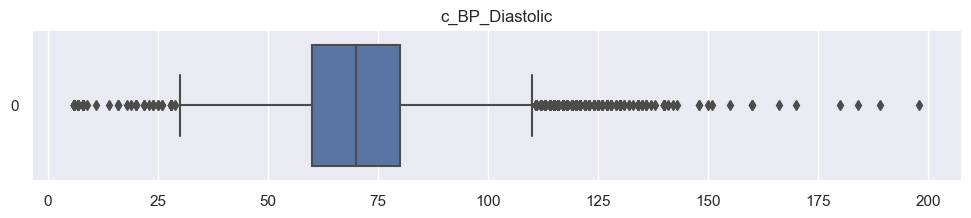

In [177]:
scii = sci.clean_blood_pressure()
single_boxplot(scii, "c_BP_Systolic")
single_boxplot(scii, "c_BP_Diastolic")



### Respiration Rate

We follow the previous methodology for supplementing scores and values. There are no clear guidelines on cutoff points for the respiration rate, as [Fernandes20] only excludes values $>80$. As an (outwardly) reasonable starting point we also exclude values $<5$. 

Triple-digit values such as 250 are assumed to mean 25. Negative values are inverted. 

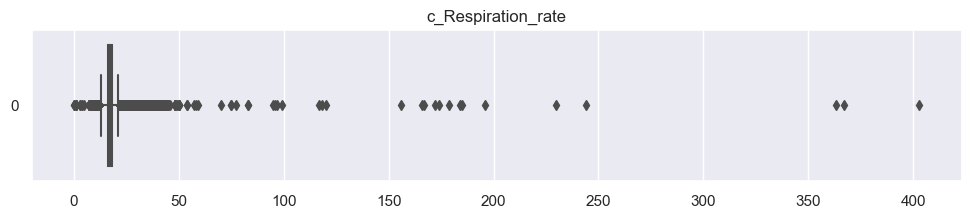

In [178]:
single_boxplot(sci, "c_Respiration_rate")



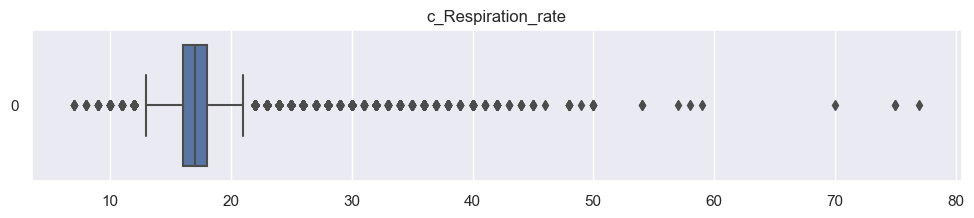

In [179]:
scii = sci.clean_respiration_rate()
single_boxplot(scii, "c_Respiration_rate")



### Device Air

Just filling missing values between the score and value columns.

In [180]:
scii = sci.clean_device_air()


### Temperature

[Fernandes20] gives $20$ as the low-end cutoff for temperature. I increase this to $25$ as it seems more reasonable.

Within 3 std. is $35.22-38.30$

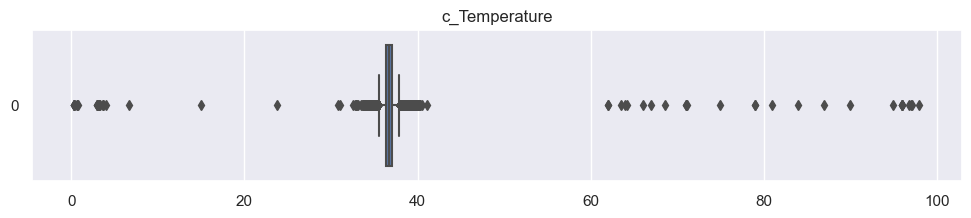

In [181]:
single_boxplot(sci, "c_Temperature")



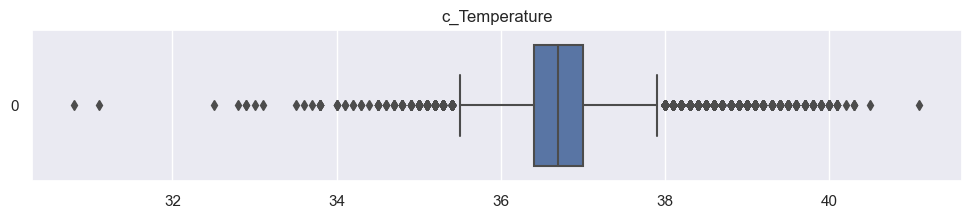

In [182]:
scii = sci.clean_temperature()
single_boxplot(scii, "c_Temperature")



### Heart Rate

[Fernandes20] eliminates values over 300. Within 3 std is $34.47-127.3$.

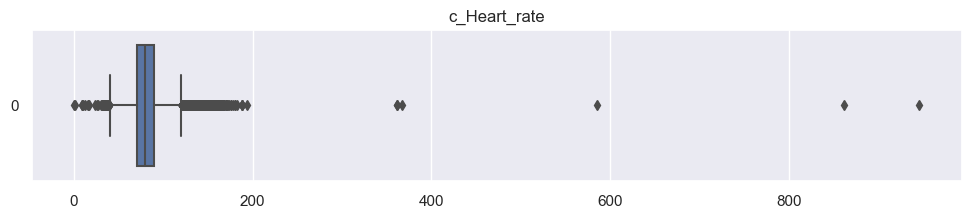

In [183]:
single_boxplot(sci, "c_Heart_rate")



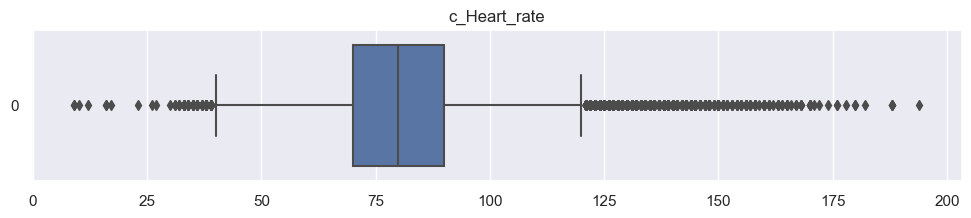

In [184]:
scii = sci.clean_heart_rate()
single_boxplot(scii, "c_Heart_rate")



### Consciousness

This can be un-binarised to allow all options for CVPU. However, the number of samples is quite small.

In [185]:
scii = sci.clean_consciousness()


### Oxygen Flow Rate

I am assuming this is measured in LPM (Litres Per Minute) as this fits with N - Nasal Cannula patients receiving 1.0-2.0 in most cases. 

If that is the case, values above 10 are unlikely so I'll assume they are erroneous and divide them by 10. 

In [186]:
sci.c_Oxygen_flow_rate.mean()

0.5541313678613957

In [187]:
(sci.c_Oxygen_flow_rate > 10).sum()

1034

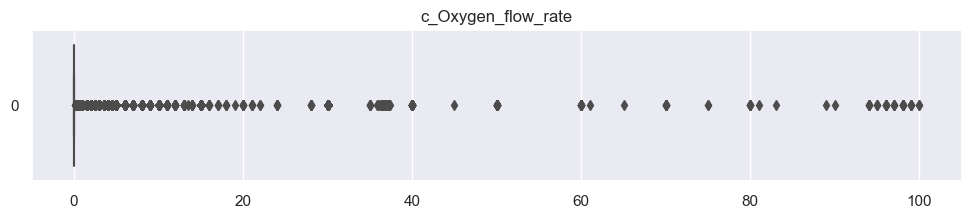

In [188]:
single_boxplot(sci, "c_Oxygen_flow_rate")



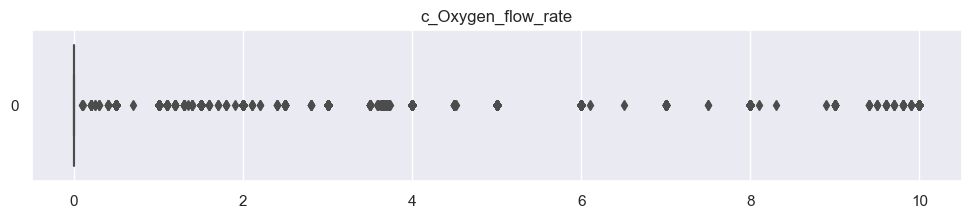

In [189]:
scii = sci.clean_O2_flow()
single_boxplot(scii, "c_Oxygen_flow_rate")



## Blood

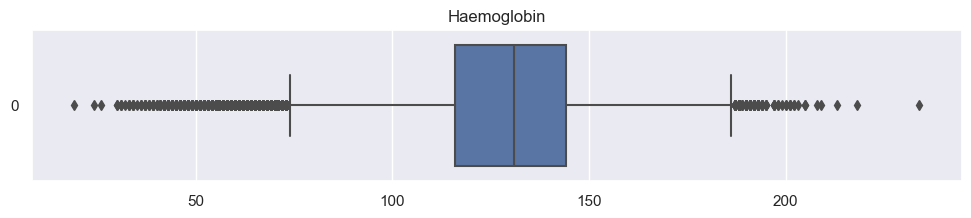

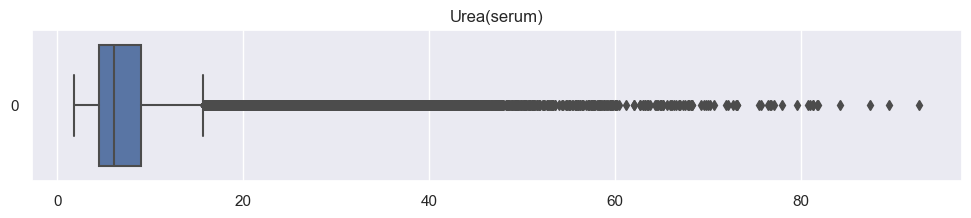

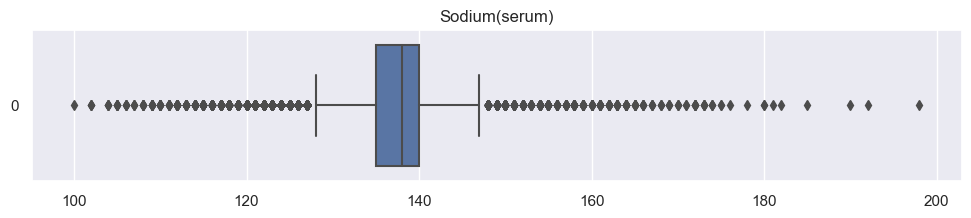

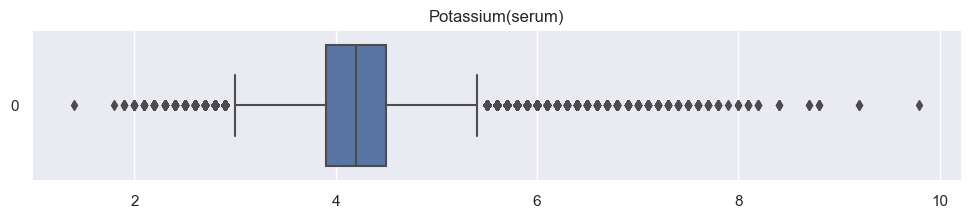

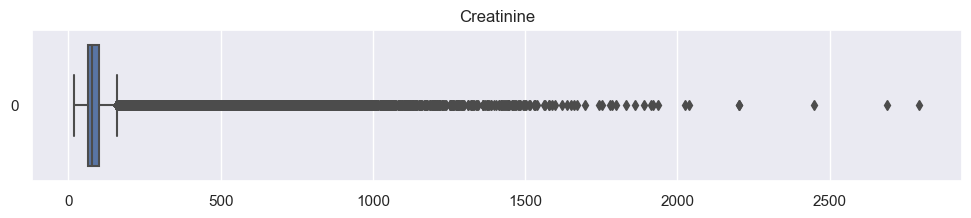

In [190]:
for col in SCICols.blood:
    single_boxplot(sci, col)


## Venous Blood Gas

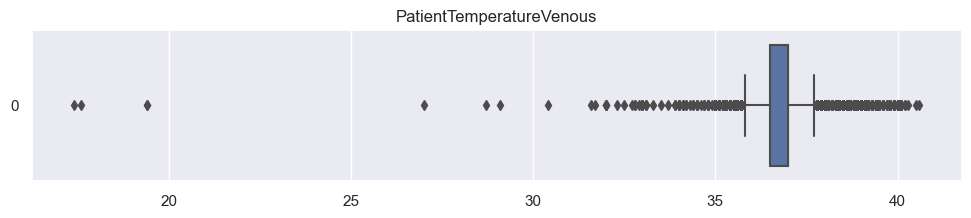

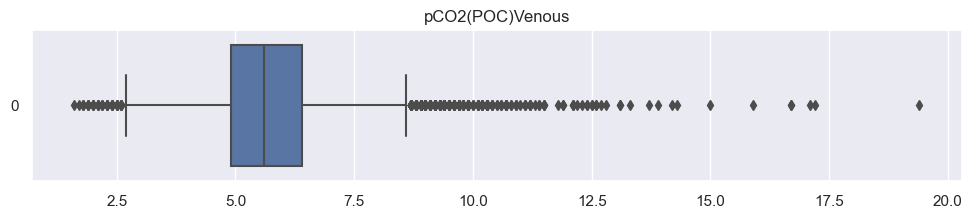

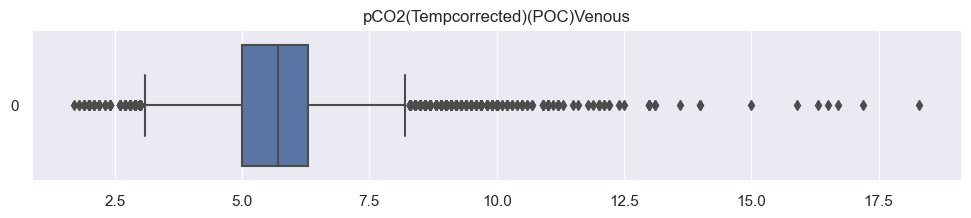

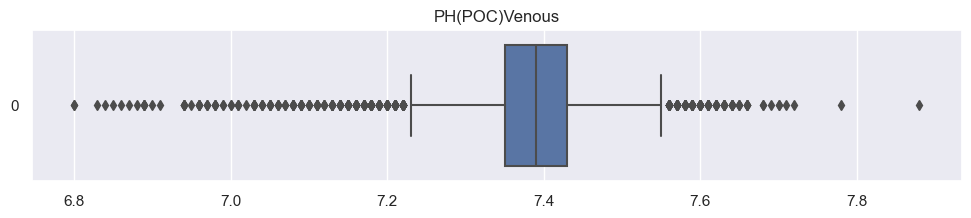

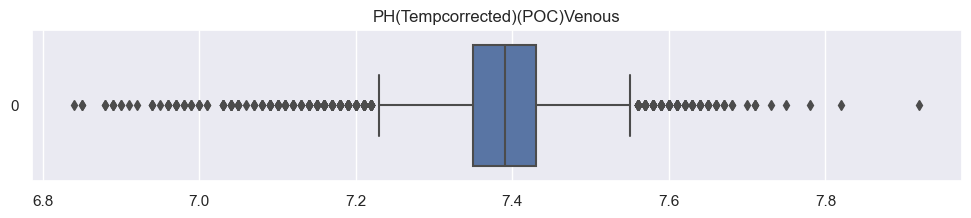

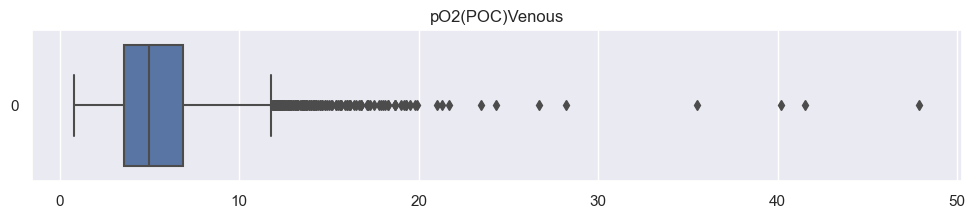

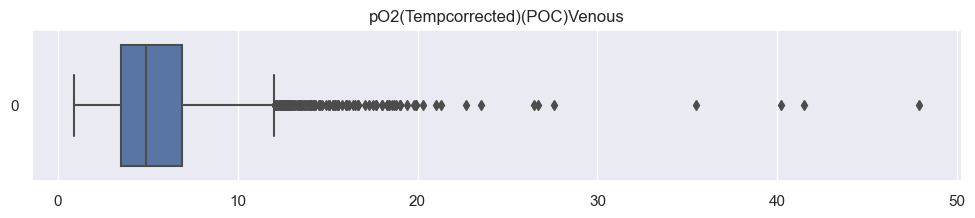

In [191]:
for _ in SCICols.vbg:
    single_boxplot(sci, _)


## A&E Unstructured Text

### Presenting Complaint

The top 50 most frequent values for this field (after some basic cleaning) make up 97.06% of entries that have a presenting complaint. Filtering out "vague" complaints such as 'unwell adult' (which happens to be the #1 most frequent value) doesn't alter the proportion by much (96.32%).

In [192]:
scii = sci.clean_ae_text()
col = scii.AandEPresentingComplaint
round(col.value_counts().head(50).sum() / col.notna().sum() * 100, 2)



96.32

### Main Diagnosis
Contrarily, the top 50 most frequent values for this field only make up 61.63% of entries that have a presenting complaint. However, the outcomes are still distributed similarly. Removing vague entries reduces this to 52.62%.

The #2 most frequent value is "referral to service (procedure)". What do we make of this?

In [193]:
col = scii.AandEMainDiagnosis.str.lower().str.strip(" ?+")
round(col.value_counts().head(50).sum() / col.notna().sum() * 100, 2)



52.62

In [194]:
stops, vec = frozenset(stopwords.words("english")), CountVectorizer()
X = vec.fit_transform(sci.clean_ae_text().AandEMainDiagnosis.dropna().values)


In [195]:
print(
    "Top 20 words: "
    + ", ".join(
        [
            word
            for freq, word in sorted(
                zip(X.sum(axis=0).tolist()[0], vec.get_feature_names_out()),
                reverse=True,
            )
            if word not in stops
        ][:20]
    )
)



Top 20 words: disorder, finding, pain, acute, syndrome, disease, chest, injury, pneumonia, overdose, tract, adults, chronic, septicemia, coronary, abdominal, obstructive, urinary, detected, abnormality


We can generate a contextualised word embedding using Bio_Clinical BERT. 

For BERT we do this by omitting the decoders from the model and accessing the hidden layers. [They](http://jalammar.github.io/illustrated-bert/) mention that concatenating the final 4 layers gives the best performance (very close to a fine-tuned BERT for NER) but we will sum instead. This reduces dimensionality but performance is comparable. 

We skip subword pooling as I don't have time to wrap my head around it and it has been found not to be very important in named entity recognition tasks ([source](https://arxiv.org/pdf/2102.10864.pdf)). 



In [196]:
config = tr.AutoConfig.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT",
    output_hidden_states=True,
    output_attentions=False,
)
tokenizer, model = (
    tr.AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT"),
    tr.AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", config=config),
)



KeyboardInterrupt: 

In [ ]:
def get_hidden(encoded, model, layers=[-4, -3, -2, -1]):
    """ Equivalent to TransformersEmbedder() with no subword pooling and "sum" layer pooling """
    with torch.no_grad():
        output = model(**encoded, output_hidden_states=True)

    return torch.stack([output.hidden_states[i] for i in layers]).sum(0).squeeze()


In [ ]:
encoded = tokenizer(
    scii.AandEMainDiagnosis.dropna().values[:1000].tolist(),
    padding=True,
    return_tensors="pt",
)
embeddings = get_hidden(encoded, model)
embeddings.shape


torch.Size([1000, 20, 768])

The output corresponding to `[CLS]` can be thought of as an embedding for the entire sentence (see [here](https://github.com/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb)). Can we make use of this?

In [ ]:
cls_embeddings = embeddings[:, 0, :]



### Patient Group Description

Seems reasonable to group some uncommon terms under more common ones:
 - "falls", "road traffic accident", "sports injury" -> "accident"
 - "knife injuries" -> "assault"

In [197]:
sci.clean_ae_patient_group().AandEPatientGroupDescription.value_counts()


medical             100675
other                40854
surgical              4463
trauma                3706
psychiatric           2751
ortho non trauma      1370
ent                    972
obs/gyn                812
neurosurgical          669
Name: AandEPatientGroupDescription, dtype: int64

## ICD-10

Around ~16k entries end with ' D' or ' A', or '.X'. These can't be matched with the external ICD-10 table so these endings are deleted. 

A tiny subset of (otherwise valid) remaining ICD-10 codes don't exist in the table. We delete these.

In [198]:
print(f'Unmatched values before: {(~sci.MainICD10.isin(icd10.index) & sci.MainICD10.notna()).sum()}')

Unmatched values before: 19376


In [199]:
scii = sci.clean_icd10(icd10)
print(f'Unmatched values after: {(~scii.MainICD10.isin(icd10.index) & scii.MainICD10.notna()).sum()}')

Unmatched values after: 0


[Hassani15] gives a set of ICD-10 codes considered "vague", such as those only describing generic symptoms (e.g., R00-R56). We can filter those out and justify the columns such that, if the Main ICD-10 was vague, the first non-vague ICD-10 becomes the Main.

In [200]:
ranges = [
    ("R", 00, 56),
    ("R", 58, 64),
    ("R", 66, 94),
    ("V", 1, 98),
    ("Z", 00, 13),
    ("Z", 20, 29),
    ("Z", 32, 36),
    ("Z", 39, 39),
    ("Z", 43, 48),
    ("Z", 52, 99),
]

vague = frozenset(f"{letter}{str(num).zfill(2)}" for letter, start, stop in ranges for num in range(start, stop + 1))

print(f'Vague ICD-10s: {sci[SCICols.diagnoses].apply(lambda c: c.str[:3]).isin(vague).sum().sum()}')
print(sci[SCICols.diagnoses].apply(lambda c: c.str[:3]).isin(vague).sum())

Vague ICD-10s: 227014
MainICD10    37225
SecDiag1     34819
SecDiag2     33864
SecDiag3     31653
SecDiag4     30559
SecDiag5     29703
SecDiag6     29191
dtype: int64


In [201]:
scii = sci.filter_vague_diagnoses()
print(f'Vague ICD-10s: {scii[SCICols.diagnoses].apply(lambda c: c.str[:3]).isin(vague).sum().sum()}')
print(scii[SCICols.diagnoses].apply(lambda c: c.str[:3]).isin(vague).sum())

Vague ICD-10s: 0
MainICD10    0
SecDiag1     0
SecDiag2     0
SecDiag3     0
SecDiag4     0
SecDiag5     0
SecDiag6     0
dtype: int64


### Augmenting

In [202]:
ccs = pd.read_hdf('data/ccs.h5', 'codes')
scii = sci.clean_icd10().filter_vague_diagnoses()

CCS Grouping: matches are near-perfect (99.28% match) excluding:
 - Some trauma-related codes: `Yxx.x`, `Wxx.x`
 - Some codes that are near-matches if you do 4-character matching (e.g. `Mxx.xx`) or 3-characters.

In [212]:
print(f'Unmatched: {(scii.join(ccs, on=scii.MainICD10.str.replace(".", "")).CCSGroup.isna() & scii.MainICD10.notna()).sum()}')

Unmatched: 1205


In [213]:
print(f'Unmatched after fuzzy: {(scii.augment_ccs(sentinel=[np.nan, np.nan]).CCSGroup.isna() & scii.MainICD10.notna()).sum()}')

Unmatched after fuzzy: 858


SHMI Grouping: Groups several CCS codes into 157 diagnostic groups. See [SHMI22] for details.

In [218]:
scii.augment_ccs().augment_shmi()[['SHMIGroup', 'SHMIGroupDescription']].head()

,SHMIGroup,SHMIGroupDescription
0,132.0,Poisoning
1,110.0,Other non-traumatic joint disorders
2,38.0,"Nutritional, endocrine and metabolic disorders"
3,132.0,Poisoning
4,132.0,Poisoning


HSMR Grouping: Groups CCS further into 17 broad aggregate clusters. Applied in the Netherlands but consistent with SHMI. See [HSMR18] for details.

In [217]:
scii.augment_ccs().augment_hsmr()[['AggregateGroup', 'AggregateGroupDescription']].head()

,AggregateGroup,AggregateGroupDescription
0,16.0,Injury and poisoning
1,13.0,Diseases of the musculoskeletal system and con...
2,3.0,"Endocrine, nutritional and metabolic diseases,..."
3,16.0,Injury and poisoning
4,16.0,Injury and poisoning
